<a href="https://colab.research.google.com/github/fralfaro/MAT281_2022/blob/main/labs/lab_10/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°10

<a id='p1'></a>
## I.- Problema 01

Lista de actos delictivos registrados por el Service de police de la Ville de Montréal (SPVM).


<img src="http://henriquecapriles.com/wp-content/uploads/2017/02/femina_detenida-1080x675.jpg" width="480" height="360" align="center"/>

El conjunto de datos en estudio `interventionscitoyendo.csv` corresponde a  todos los delitos entre 2015 y agosto de 2020en Montreal. Cada delito está asociado en grandes categorías, y hay información sobre la ubicación, el momento del día, etc.

> **Nota**: Para más información seguir el siguiente el [link](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).

In [2]:
# librerias 

import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [3]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]
    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [4]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281_2022/main/labs/lab_10/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [20]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()

El objetivo de este laboratorio es poder realizar un análisis completo del conjunto de datos en estudio, para eso debe responder las siguientes preguntas:

1. Realizar un gráfico para cada serie temporal $y\_{si}, i =1,2,3,4$.


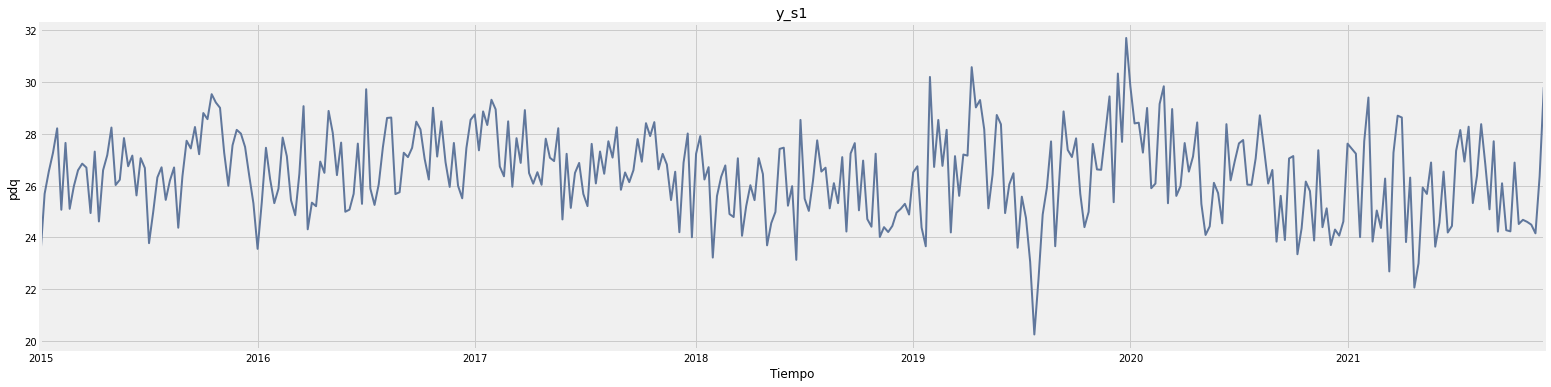

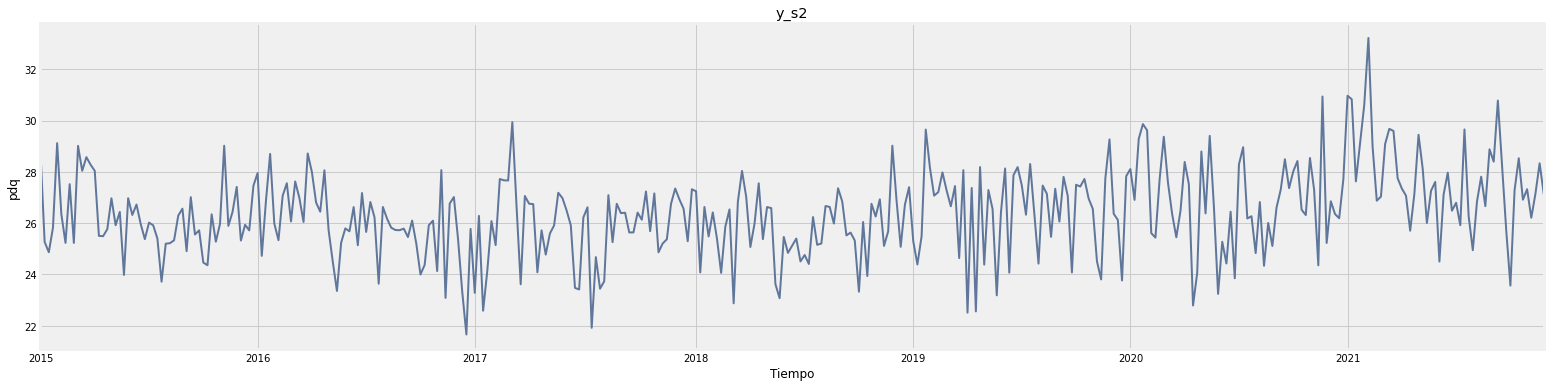

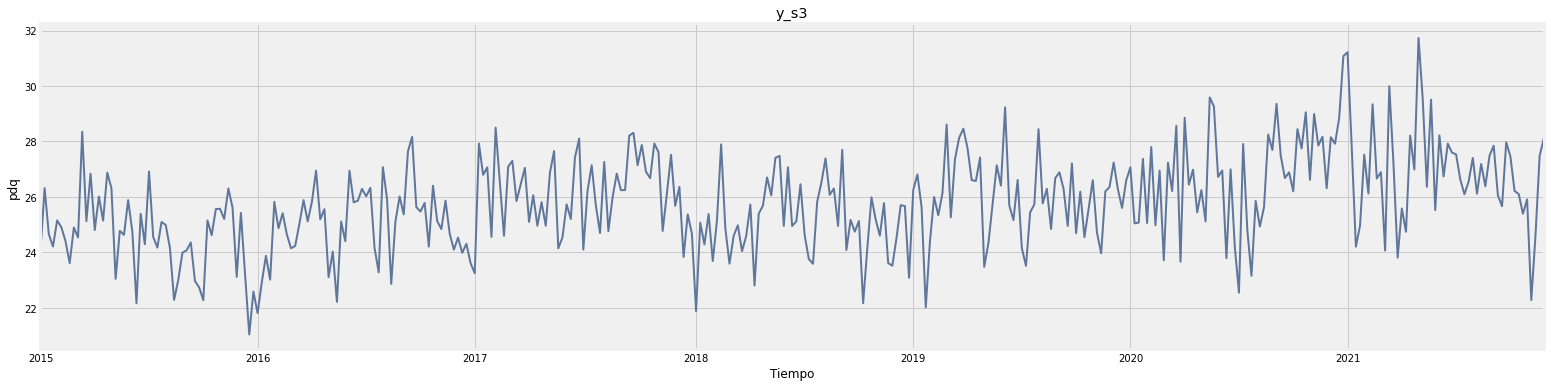

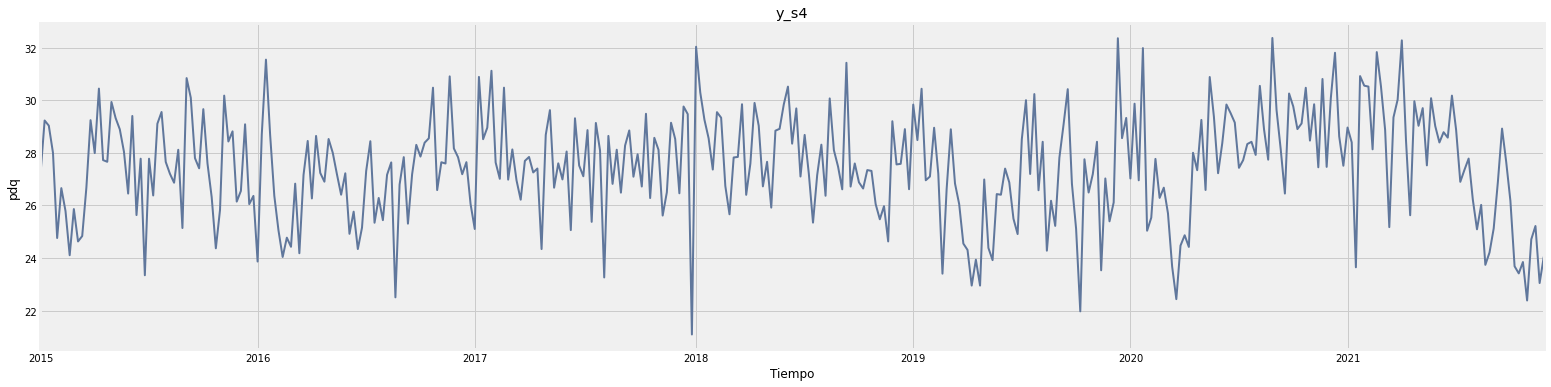

In [6]:
I = [0,1,2,3]
Y = [y_s1,y_s2,y_s3,y_s4]
for i in I:
  Y[i].plot(figsize = (24,6), linewidth = 2)
  i+=1
  plt.xlabel("Tiempo")
  plt.ylabel("pdq")
  plt.title("y_s"+str(i))
  plt.legend().remove()
plt.show()

2. Escoger alguna serie temporal $y\_{si}, i =1,2,3,4$. Luego:

* Realizar un análisis exploratorio de la serie temporal escogida
* Aplicar el modelo de pronóstico $SARIMA(p,d,q)x(P,D,Q,S)$, probando varias configuraciones de los hiperparámetros. Encuentre la mejor configuración. Concluya.
* Para el mejor modelo encontrado, verificar si el residuo corresponde a un ruido blanco.

> **Hint**: Tome como `target_date` =  '2021-01-01'. Recuerde considerar que su columna de valores se llama `pdq`.


In [7]:
class SarimaModels:
    def __init__(self,params):

        self.params = params
    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')
    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date
        y_train = y[mask_ds]
        y_test = y[~mask_ds]        
        return y_train, y_test
    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        model_fit = model.fit(disp=0)
        return model_fit    
    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        model_fit = model.fit(disp=0)
        start_index = y_test.index.min()
        end_index = y_test.index.max()
        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )
        return df_temp
    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model
        return df_metrics

Analisis Exploratorio
* Comenzamos viendo la estructura y rango de los datos, estos solo contienen un valor numerico por cada semana desde Enero 2015 a Noviembre 2021

In [21]:
y_s1.head()

,pdq
date,
2015-01-04,23.337079
2015-01-11,25.687861
2015-01-18,26.547170
2015-01-25,27.267016
2015-02-01,28.213018


In [22]:
y_s1.tail()

,pdq
date,
2021-10-31,24.603306
2021-11-07,24.494949
2021-11-14,24.160000
2021-11-21,26.363636
2021-11-28,29.806452


Vemos sus valores representativos mas importantes y nos fijamos en varias cosas
* No hay outliers
* Datos muy homogenos ya que mediana = media
* Complementando lo anterior 50% - 25% casi igual 75% - 50%

In [23]:
y_s1.describe()

,pdq
count,361.000000
mean,26.437394
std,1.658831
min,20.255319
25%,25.227586
50%,26.515873
75%,27.611940
max,31.702479


Trabajamos los valores Nulos en 2 pasos
* Los contamos para saber que en cantidad no son comparables con el total de datos
* Los reemplazamos por el valor promedio o el mas cercano (valor siguiente/anterior)

In [27]:
y_s1.isnull().sum()
#como no hay valores nulos no reemplazamos nada

pdq    0
dtype: int64

Buscamos relacion Año-pdq

In [11]:
años = ["2015","2016","2017","2018","2019","2020","2021"]
for año in años:
  x = round(y_s1[año:año]["pdq"].mean(),4)
  txt = "Promedio %s: %f"%(año,x)
  print(txt)

Promedio 2015: 26.732900
Promedio 2016: 26.732000
Promedio 2017: 26.984400
Promedio 2018: 25.734900
Promedio 2019: 26.614800
Promedio 2020: 26.332300
Promedio 2021: 25.876800


Vemos a pdq constante a traves de los años pero con una ligera caida

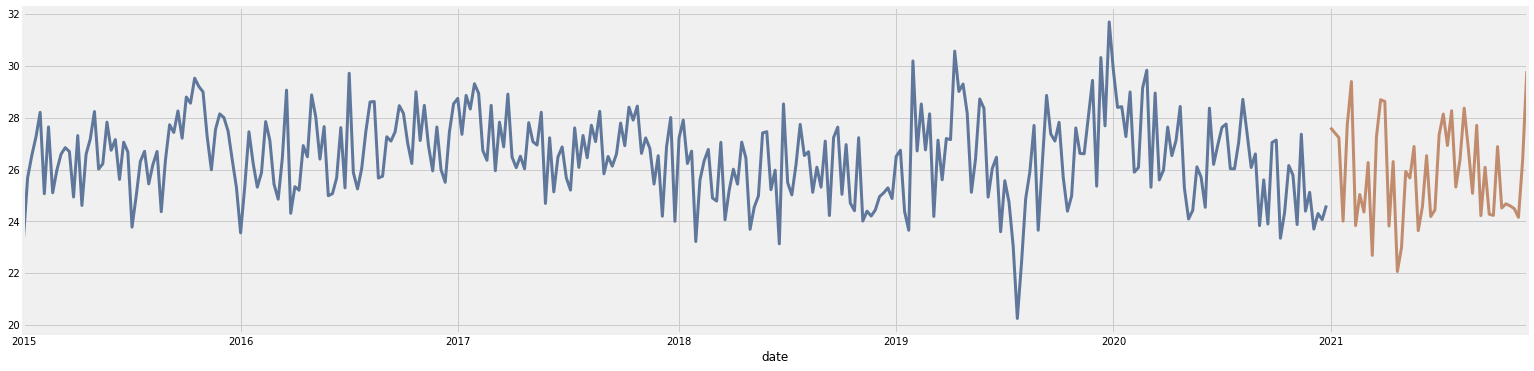

In [12]:
y = y_s1
target_date = '2021-01-01'
mask_ds = y.index < target_date

y_train = y[mask_ds]
y_test = y[~mask_ds]

y_train['pdq'].plot(figsize = (24,6), linewidth = 3)
y_test['pdq'].plot(linewidth = 3)
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


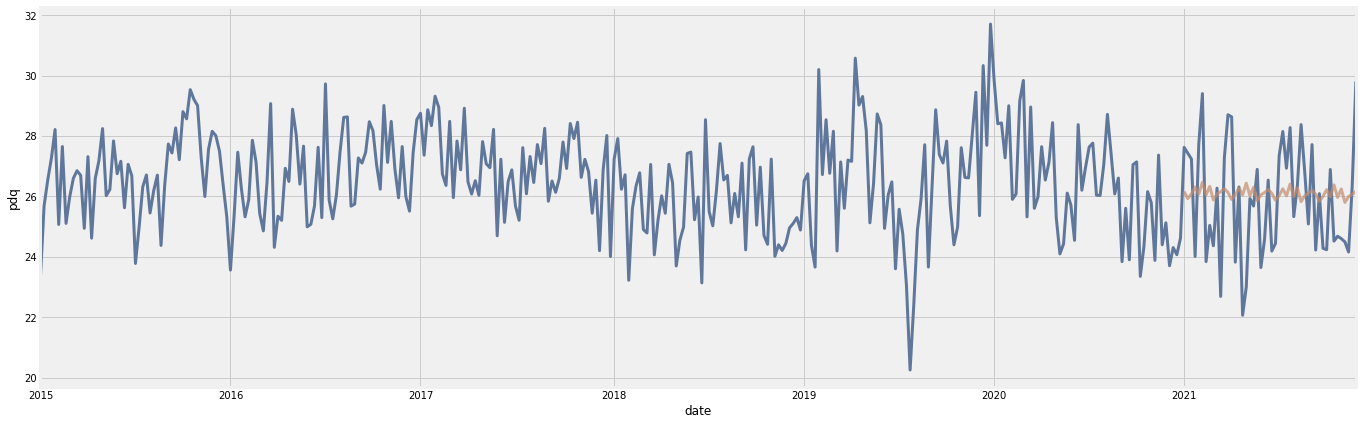

In [13]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
params = list(itertools.product(pdq,seasonal_pdq))
min = 1000
mindf = 0
for param in params:
  model = SARIMAX(y_train,
                          order=param[0],
                          seasonal_order=param[1],
                          enforce_stationarity=False,
                          enforce_invertibility=False)
  model_fit = model.fit(disp=0)       
  start_index = y_test.index.min()
  end_index = y_test.index.max()
  preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
  df_temp = pd.DataFrame(
              {
                  'y':y_test['pdq'],
                  'yhat': preds.predicted_mean
              }
          )
  df_metrics = summary_metrics(df_temp)
  df_metrics['model'] = f"SARIMA_{param[0]}X{param[1]}".replace(' ','')
  x=df_metrics["mape"][0]
  if(x < min):
    min = x
    mindf = df_temp

preds = mindf['yhat']
ax = y['2015-01-01':].plot(label='observed', linewidth = 3)
preds.plot(ax=ax, label='Sarima', alpha=.7, figsize=(21, 7),linewidth = 3)
ax.set_xlabel('date')
ax.set_ylabel('pdq')
plt.legend().remove()
plt.show()

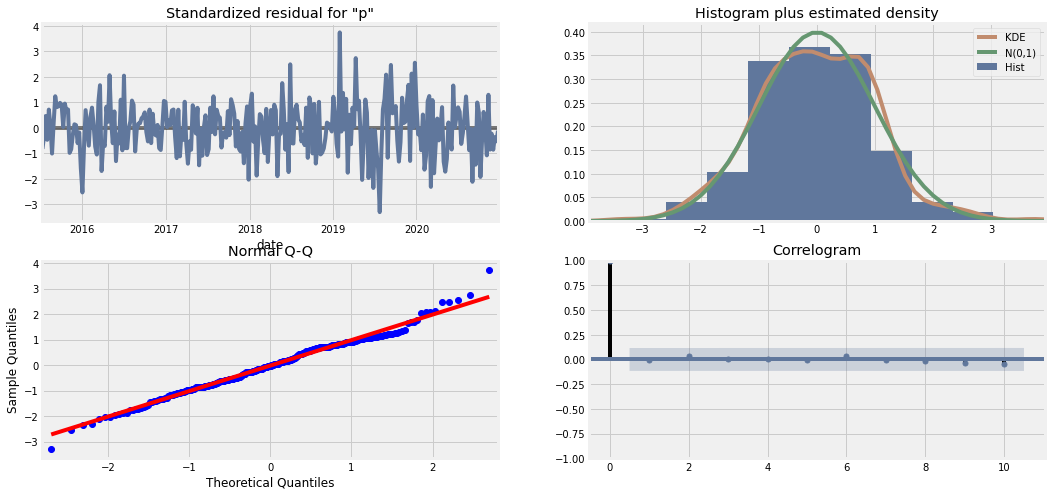

In [14]:
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

Como el grafico oscila en torno a cero podemos concluir que el ruido es ruido blanco (sino aumentaria o disminuiria constantemente)

3. Resuelva el ejercicio anterior utilizando la librería de `Prophet`.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqpxv7o6m/nowgq9l4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqpxv7o6m/ntdycwhq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29295', 'data', 'file=/tmp/tmpqpxv7o6m/nowgq9l4.json', 'init=/tmp/tmpqpxv7o6m/ntdycwhq.json', 'output', 'file=/tmp/tmpqpxv7o6m/prophet_modelq4a_n78j/prophet_model-20221112003237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:32:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:32:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


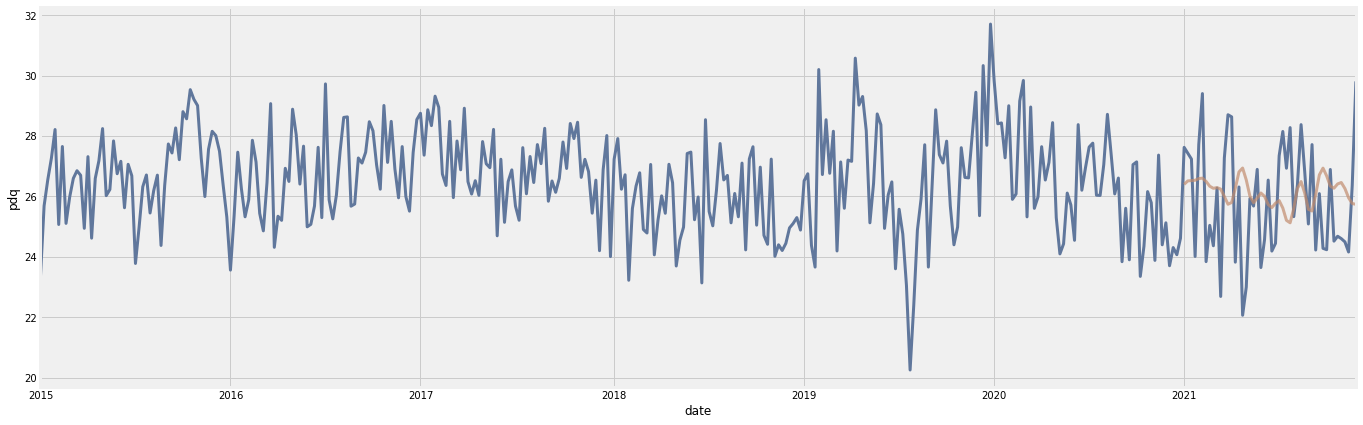

In [28]:
from prophet import Prophet
y_train_prophet = y_train.reset_index()
y_train_prophet.columns = ["ds","y"]

y_test_prophet = y_test.reset_index()
y_test_prophet.columns = ["ds","y"]
m = Prophet()
m.fit(y_train_prophet)
future = m.make_future_dataframe(periods=365*4)
forecast = m.predict(future)[['ds', 'yhat']]
result = y_test_prophet.merge(forecast,on = 'ds',how='inner')
metricas = summary_metrics(result)
preds = result[['ds','yhat']].set_index("ds")
ax = y['2015-01-01':].plot(label='observed', linewidth = 3)
preds.plot(ax=ax, label='Forecast', alpha=.7, figsize=(21, 7), linewidth = 3)

ax.set_xlabel('date')
ax.set_ylabel('pdq')
plt.legend().remove()
plt.show()